In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

from itertools import product

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
np.random.seed(123)
torch.manual_seed(123)

### Step 1: Generate Data

In [62]:
from synthetic.generate import SingleTaskTreeDepsGenerator

K = 2
M = 5
N = 10000

# Generate the true class balance to be recovered
class_balance = np.ones(K)/K + np.random.random(K)/5.
class_balance /= class_balance.sum()

#, edges=[(0,1)]
data = SingleTaskTreeDepsGenerator(N, M, K, class_balance, edges=[(0,1)])
print (f"LF Dependencies: {data.E}")
print (f"Class Balance: {data.p}")

LF Dependencies: [(0, 1)]
Class Balance: [0.50537711 0.49462289]


In [63]:
from metal.analysis import lf_summary
lf_summary(data.L,data.Y)

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",0.8663,0.8662,0.5327,7332,1331,0.846358
1,"[1, 2]",0.9083,0.9077,0.5525,8121,962,0.894088
2,"[1, 2]",0.8537,0.8504,0.5229,7046,1491,0.825348
3,"[1, 2]",0.7481,0.7466,0.4864,5065,2416,0.677049
4,"[1, 2]",0.7313,0.7304,0.4829,4628,2685,0.632846


### Step 2: Learn Dependencies using `DependencyLearnerModel`
**TEMP: hardcoding for now**

In [64]:
edges = data.E
L = np.array(data.L.todense())

### Step 3: Recover the class balance using subset of independent LFs

In [65]:
# Generate indices for independent LFs
ind_lfs = []
for i in range(M):
    if i not in list(sum(edges, ())):
        ind_lfs.append(i)
L_ind = L[:,ind_lfs]

In [66]:
%%time
from metal.label_model.class_balance import ClassBalanceModel

cb_model = ClassBalanceModel(K, abstains=True)
cb_model.train_model(L=L_ind, verbose=False)

print(f"Estimated class balance: {cb_model.class_balance}")
print(f"True class balance: {class_balance}")
print()

Estimated class balance: [1.9675406 1.9675406]
True class balance: [0.50537711 0.49462289]

CPU times: user 4.46 s, sys: 32 ms, total: 4.49 s
Wall time: 290 ms


# Debugging

In [140]:
np.min(np.abs(np.linalg.inv(O_inv)))

0.0014439869

Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=3.460]
[2 epo]: TRAIN:[loss=3.443]
[3 epo]: TRAIN:[loss=3.410]
[4 epo]: TRAIN:[loss=3.364]
[5 epo]: TRAIN:[loss=3.304]
Finished Training


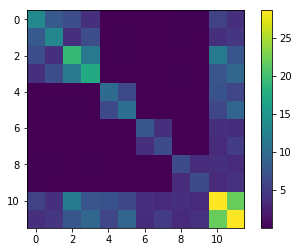

In [141]:
L = np.array(data.L.todense())
Y = np.array(data.Y,)
L = np.vstack((L.T,Y)).T

from metal.label_model import LabelModel
label_model = LabelModel(verbose=True,k=K, seed=123)

label_model.train_model(
    L, 
    #deps = edges, 
    lr = 1e-3,
    n_epochs=5,
    log_every=5
)

import matplotlib.pyplot as plt
%matplotlib inline

O_inv = label_model.O.detach().numpy()
plt.imshow(np.abs(np.linalg.inv(O_inv)))
plt.colorbar()

### Step 4: Train `LabelModel` using $\mu$ from `ClassBalanceModel`

In [8]:
%%time
from metal.label_model import LabelModel
label_model = LabelModel(verbose=True,k=K, seed=123)

label_model.train_model(
    data.L, 
    cond_probs = cb_model.cond_probs, 
    ind_lfs = ind_lfs, 
    deps = edges, 
    #class_balance = cb_model.class_balance.astype(float),
    lr = 1e-3, 
    n_epochs = 500, 
    log_train_every = 500,
    l2=5e-1
)

print()
for y in range(K):
    mu_idx = [il*K + y for il in ind_lfs]
    diff = np.linalg.norm(label_model.mu[mu_idx,y].detach().numpy() - 
                         label_model.mu_init[mu_idx,y].detach().numpy())/(M*1.0)
    print(f"Diff between mu and mu_init for y = {y+1}: {diff}")
print()

Computing O^{-1}...
Estimating Z...
[500 epo]: TRAIN:[loss=72.772]
Finished Training
Estimating \mu...
[500 epo]: TRAIN:[loss=0.569]
Finished Training

Diff between mu and mu_init for y = 1: 0.00588935874402523
Diff between mu and mu_init for y = 2: 0.013966070115566253
Diff between mu and mu_init for y = 3: 0.0063605673611164095

CPU times: user 15.5 s, sys: 3.35 s, total: 18.8 s
Wall time: 1.02 s


In [9]:
print('Trained Label Model Metrics:')
scores = label_model.score((data.L, data.Y), metric=['accuracy','precision', 'recall', 'f1'])

Trained Label Model Metrics:
Accuracy: 0.951
Precision: 0.940
Recall: 0.964
F1: 0.952
        y=1    y=2    y=3   
 l=1   3693    173    61    
 l=2    48    2941    29    
 l=3    90     87    2878   


### Step 4b: Compare to MajorityVote and No Class Balance+Dependencies LabelModel

**Baseline: No Class Balance or Dependencies**

In [10]:
%%time
from metal.label_model import LabelModel
label_model = LabelModel(k=K, seed=123)

label_model.train_model(data.L, lr=1e-3, n_epochs=500, log_train_every=50)

Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.150]
[100 epo]: TRAIN:[loss=0.058]
[150 epo]: TRAIN:[loss=0.029]
[200 epo]: TRAIN:[loss=0.017]
[250 epo]: TRAIN:[loss=0.013]
[300 epo]: TRAIN:[loss=0.011]
[350 epo]: TRAIN:[loss=0.010]
[400 epo]: TRAIN:[loss=0.009]
[450 epo]: TRAIN:[loss=0.009]
[500 epo]: TRAIN:[loss=0.009]
Finished Training
CPU times: user 14.7 s, sys: 100 ms, total: 14.8 s
Wall time: 538 ms


In [11]:
print('Trained Label Model Metrics:')
scores = label_model.score((data.L, data.Y), metric=['accuracy','precision', 'recall', 'f1'])

Trained Label Model Metrics:
Accuracy: 0.955
Precision: 0.956
Recall: 0.957
F1: 0.957
        y=1    y=2    y=3   
 l=1   3668    131    36    
 l=2    68    2978    25    
 l=3    95     92    2907   


**Baseline: Majority Vote**

In [12]:
from metal.label_model.baselines import MajorityLabelVoter

mv = MajorityLabelVoter(k=K,seed=123)
print('Majority Label Voter Metrics:')
scores = mv.score((data.L, data.Y), metric=['accuracy','precision', 'recall', 'f1'])

Majority Label Voter Metrics:
Accuracy: 0.944
Precision: 0.951
Recall: 0.950
F1: 0.951
        y=1    y=2    y=3   
 l=1   3640    134    52    
 l=2    90    2937    51    
 l=3    101    130   2865   
